In [1]:
import pandas as pd
import os
IMPACT_CWD=os.path.expanduser("~")+"/Downloads/" 
input_book = pd.ExcelFile(IMPACT_CWD+'心理検査DB_差分入り.xlsx')
input_exc = pd.ExcelFile(IMPACT_CWD+'Synapsology.運動習慣.xlsx')
result_lh_df = pd.read_table(IMPACT_CWD+"lh.thick.spc.csv", delim_whitespace=True)
result_rh_df = pd.read_table(IMPACT_CWD+"rh.thick.spc.csv", delim_whitespace=True)

#sheet_namesメソッドでExcelブック内の各シートの名前をリストで取得できる
input_sheet_name = input_book.sheet_names
exc_sheet_name = input_exc.sheet_names

#DataFrameとして一つ目のsheetを読込
exc_sheet_df = input_exc.parse(exc_sheet_name[0])
exc_sheet_df=exc_sheet_df.drop(exc_sheet_df.columns[[2,3,4]],axis=1)
exc_sheet_df.loc[(exc_sheet_df[exc_sheet_df.columns[2]] == 0), exc_sheet_df.columns[2]] = 0
exc_sheet_df.loc[(exc_sheet_df[exc_sheet_df.columns[2]] > 0) & (exc_sheet_df[exc_sheet_df.columns[2]] < 5), exc_sheet_df.columns[2]] = 1
exc_sheet_df.loc[(exc_sheet_df[exc_sheet_df.columns[2]] >= 5), exc_sheet_df.columns[2]] = 2

In [2]:
#DataFrameとして一つ目のsheetを読込
fu_sheet_df = input_book.parse(input_sheet_name[0])
fu_sheet_df=fu_sheet_df[fu_sheet_df[fu_sheet_df.columns[0]].str.contains("",na=False)]

#読み込んだシート名の確認
print("Sheet name:", input_sheet_name[0])

fu_sheet_df=fu_sheet_df.iloc[:,0:24]
fu_sheet_df=fu_sheet_df.drop(fu_sheet_df.columns[[21,22]],axis=1)
#読み込んだシートの先頭5行を表示
#print(fu_sheet_df.shape)
print(fu_sheet_df.head(5))

Sheet name: follow_without29
     研究ID        検査日    年齢  性別\n1：男性\n２：女性  TMT-A\n（秒）  TMT-B\n（秒）  TMT\nB-A  \
0  U28001 2016-12-08  64.0             2.0        73.0        84.0      11.0   
1  U28002 2016-11-25  64.0             2.0        75.0        94.0      19.0   
2  U28003 2016-12-09  63.0             2.0        77.0        93.0      16.0   
3  U28004 2016-12-13  63.0             2.0        49.0       122.0      73.0   
4  U28005 2016-12-16  58.0             2.0        54.0        98.0      44.0   

   TMT\nB/A   CA  NUCA  ...  PEN  EEPM  EEPN  MSC  DMS   UE   BR  %PEM  %PEN  \
0  1.150685  6.0   1.0  ...  0.0   8.0   8.0  4.0  0.0  0.0  0.0   0.0   0.0   
1  1.253333  4.0   2.0  ...  6.0  20.0  18.0  3.0  0.0  0.0  0.0  16.6  25.0   
2  1.207792  6.0   1.0  ...  0.0   8.0   8.0  4.0  0.0  0.0  0.0   0.0   0.0   
3  2.489796  5.0   2.0  ...  1.0  11.0  11.0  5.0  1.0  0.0  0.0   8.3   8.3   
4  1.814815  5.0   5.0  ...  2.0  14.0  13.0  2.0  0.0  1.0  0.0   6.6  13.3   

   反応時間計_

In [3]:
#DataFrameとして3つ目のsheetを読込（グラフはsheetとしてカウントされない？）
bl_sheet_df = input_book.parse(input_sheet_name[1])
bl_sheet_df=bl_sheet_df[bl_sheet_df[bl_sheet_df.columns[0]].str.contains("",na=False)]

#読み込んだシート名の確認
print("Sheet name:", input_sheet_name[1])

bl_sheet_df=bl_sheet_df.drop(bl_sheet_df.columns[[21,23,27,28]],axis=1)
#読み込んだシートの先頭5行を表示
print(bl_sheet_df.shape)#head(5))

Sheet name: baseline_without29
(51, 29)


In [4]:
bl_fu_sheet_df=pd.merge(bl_sheet_df, fu_sheet_df, left_on=bl_sheet_df.columns[0], right_on=fu_sheet_df.columns[0], how="inner", suffixes = ["_bl", "_fu"])
bl_fu_sheet_df.columns=bl_fu_sheet_df.columns.str.replace(" ","_")
bl_fu_sheet_df.columns=bl_fu_sheet_df.columns.str.replace("\n","_")
print(bl_fu_sheet_df.head(5))
bl_fu_sheet_df=pd.merge(exc_sheet_df, bl_fu_sheet_df, left_on=exc_sheet_df.columns[0], right_on=bl_fu_sheet_df.columns[0], how="inner", suffixes = ["_exc", ""])
print(bl_fu_sheet_df.shape)

     研究ID     検査日_bl  年齢_bl  性別_1：男性_２：女性_bl  TMT-A_（秒）_bl  TMT-B_（秒）_bl  \
0  U28001 2016-08-12   64.0              2.0          92.0          97.0   
1  U28002 2016-08-10   64.0              2.0          88.0          88.0   
2  U28003 2016-08-02   63.0              2.0          97.0         122.0   
3  U28004 2016-08-03   62.0              2.0          64.0          79.0   
4  U28005 2016-08-19   58.0              2.0          44.0          86.0   

   TMT_B-A_bl   TMT_B/A  CA_bl  NUCA_bl  ...  PEN_fu  EEPM_fu  EEPN_fu  \
0         5.0  1.054348    4.0      0.0  ...     0.0      8.0      8.0   
1         0.0  1.000000    4.0      3.0  ...     6.0     20.0     18.0   
2        25.0  1.257732    6.0      0.0  ...     0.0      8.0      8.0   
3        15.0  1.234375    0.0     48.0  ...     1.0     11.0     11.0   
4        42.0  1.954545    6.0      0.0  ...     2.0     14.0     13.0   

   MSC_fu  DMS_fu  UE_fu  BR_fu  %PEM_fu  %PEN_fu  反応時間計_秒_fu  
0     4.0     0.0    0.0    0.0   

In [5]:
#print(result_lh_df.head(5))
#print(result_rh_df.head(5))
bl_fu_bilateral_df=pd.merge(result_lh_df, result_rh_df, left_on=result_lh_df.columns[0], right_on=result_rh_df.columns[0], how="inner", suffixes = ["_lh", "_rh"])
print(bl_fu_bilateral_df.shape)#head(5))

(50, 75)


In [6]:
df_result=pd.merge(bl_fu_sheet_df, bl_fu_bilateral_df, left_on=bl_fu_sheet_df.columns[0], right_on=bl_fu_bilateral_df.columns[0], how="inner").sort_values(by=bl_fu_sheet_df.columns[0])
print(df_result.shape)
#print(df_result)
print(type(df_result))

(50, 127)
<class 'pandas.core.frame.DataFrame'>


In [7]:
df_result=df_result.T.drop_duplicates().T # 重複列削除
df_result=df_result.set_index("研究ID")
print(df_result.shape)
print(type(df_result))
df_result.to_csv('~/Downloads/spc_df_result.csv')
df_result = pd.read_csv('~/Downloads/spc_df_result.csv')
df_result=df_result.set_index("研究ID")
df_result=df_result.drop(columns=["検査日_bl", "検査日_fu", "年齢_fu"])
print(df_result.shape)
print(type(df_result))

(50, 120)
<class 'pandas.core.frame.DataFrame'>
(50, 117)
<class 'pandas.core.frame.DataFrame'>


In [8]:
"""from pandas import plotting
import matplotlib.pyplot as plt
# PCA
pca_result=df_result.drop(columns=["運動習慣","テストの所要時間_秒","JART_誤答数"])
#print(pca_result.iloc[:, 0].head())
#print(pca_result.iloc[:, 1:pca_result.columns.get_loc("反応時間計_秒_fu")+1].head())
plotting.scatter_matrix(pca_result.iloc[:, 1:pca_result.columns.get_loc("反応時間計_秒_fu")+1], figsize=(24, 24), c=list(pca_result.iloc[:, 0]), alpha=0.5)
#plt.show()
plt.savefig('pca.png')"""

'from pandas import plotting\nimport matplotlib.pyplot as plt\n# PCA\npca_result=df_result.drop(columns=["運動習慣","テストの所要時間_秒","JART_誤答数"])\n#print(pca_result.iloc[:, 0].head())\n#print(pca_result.iloc[:, 1:pca_result.columns.get_loc("反応時間計_秒_fu")+1].head())\nplotting.scatter_matrix(pca_result.iloc[:, 1:pca_result.columns.get_loc("反応時間計_秒_fu")+1], figsize=(24, 24), c=list(pca_result.iloc[:, 0]), alpha=0.5)\n#plt.show()\nplt.savefig(\'pca.png\')'

In [9]:
"""# PCA
#pca_result=df_result.drop(columns=["運動習慣","テストの所要時間_秒","JART_誤答数"])
#print(pca_result.iloc[:, 0].head())
print(pca_result.iloc[:, pca_result.columns.get_loc("rh_bankssts_thickness"):pca_result.columns.get_loc("rh_MeanThickness_thickness")+1].head())
plotting.scatter_matrix(pca_result.iloc[:, pca_result.columns.get_loc("rh_bankssts_thickness"):pca_result.columns.get_loc("rh_MeanThickness_thickness")+1], figsize=(24, 24), c=list(pca_result.iloc[:, 0]), alpha=0.5)
#plt.show()
plt.savefig('pca2.png')"""

'# PCA\n#pca_result=df_result.drop(columns=["運動習慣","テストの所要時間_秒","JART_誤答数"])\n#print(pca_result.iloc[:, 0].head())\nprint(pca_result.iloc[:, pca_result.columns.get_loc("rh_bankssts_thickness"):pca_result.columns.get_loc("rh_MeanThickness_thickness")+1].head())\nplotting.scatter_matrix(pca_result.iloc[:, pca_result.columns.get_loc("rh_bankssts_thickness"):pca_result.columns.get_loc("rh_MeanThickness_thickness")+1], figsize=(24, 24), c=list(pca_result.iloc[:, 0]), alpha=0.5)\n#plt.show()\nplt.savefig(\'pca2.png\')'

                                     spc      pval
15              lh_paracentral_thickness  0.016735
10     lh_lateralorbitofrontal_thickness  0.104010
21       lh_posteriorcingulate_thickness  0.193683
37  rh_caudalanteriorcingulate_thickness  0.195481
38      rh_caudalmiddlefrontal_thickness  0.204341
..                                   ...       ...
12      lh_medialorbitofrontal_thickness  0.905841
5                  lh_fusiform_thickness  0.906258
41                 rh_fusiform_thickness  0.912247
70            rh_MeanThickness_thickness  0.919063
25     lh_rostralmiddlefrontal_thickness  0.979411

[71 rows x 2 columns]


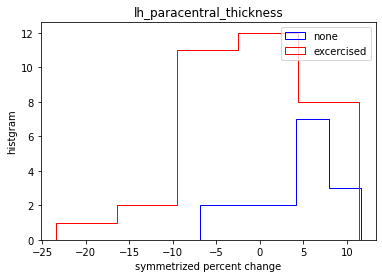

In [10]:
from scipy import stats

ttest_result_df = pd.DataFrame(index=[], columns=['spc', 'pval'])
for ii in range(df_result.columns.get_loc('lh_bankssts_thickness'),df_result.columns.get_loc('rh_MeanThickness_thickness')+1):
    ttest_A=df_result.loc[(df_result['運動習慣'] == 0),df_result.columns[ii]]
    ttest_B=df_result.loc[(df_result['運動習慣'] == 1),df_result.columns[ii]]
#    print(ttest_A.shape, ttest_A.head(5))
#    print(ttest_B.shape, ttest_B.head(5))
    ttest_result=stats.ttest_ind(ttest_A,ttest_B)
    #ttest_result=stats.ttest_rel(ttest_A,ttest_B)
    ttest_result_df=ttest_result_df.append(pd.DataFrame([[df_result.columns[ii],ttest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
print(ttest_result_df.sort_values('pval'))
#
import matplotlib.pyplot as plt
minspcname=ttest_result_df.sort_values('pval')['spc'].reset_index(drop=True)[0]
ttest_A=df_result.loc[(df_result['運動習慣'] == 0),minspcname]
ttest_B=df_result.loc[(df_result['運動習慣'] == 1),minspcname]
plt.hist(ttest_A, bins=5, histtype="step", color="b", label="none")
plt.hist(ttest_B, bins=5, histtype="step", color="r", label="excercised")
plt.title(minspcname)
plt.xlabel("symmetrized percent change")
plt.ylabel("histgram")
plt.legend()
plt.savefig(IMPACT_CWD+'figure.png')

In [11]:
from statsmodels.formula.api import ols

df_result['n運動習慣'] = 0
df_result.loc[(df_result['運動習慣'] == 0),'n運動習慣'] = 1

ftest_result_df = pd.DataFrame(index=[], columns=['spc', 'pval'])
for ii in range(df_result.columns.get_loc('lh_bankssts_thickness'),df_result.columns.get_loc('rh_MeanThickness_thickness')+1):
    ftest_A=df_result.loc[:,['年齢_bl','運動習慣','n運動習慣',df_result.columns[ii]]]
    #print(ftest_A.head())
    model=ols(df_result.columns[ii]+' ~ 運動習慣 + n運動習慣 + 年齢_bl', ftest_A).fit()
    #print(model.summary())
    ftest_result=model.f_test([0, 1, -1, 0])
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii],ftest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
print(ftest_result_df.sort_values('pval'))

                                     spc                 pval
15              lh_paracentral_thickness  0.06521633186678703
10     lh_lateralorbitofrontal_thickness  0.06855451178118473
13           lh_middletemporal_thickness  0.12322331736738659
37  rh_caudalanteriorcingulate_thickness   0.1504070320466169
19            lh_pericalcarine_thickness  0.16370644546916813
..                                   ...                  ...
39                   rh_cuneus_thickness    0.916392092924125
28         lh_superiortemporal_thickness   0.9252731407596322
67             rh_temporalpole_thickness   0.9324047385057815
61     rh_rostralmiddlefrontal_thickness    0.933111995020979
32       lh_transversetemporal_thickness   0.9539083771565285

[71 rows x 2 columns]


                                  spc      pval
43      rh_inferiortemporal_thickness  0.024123
15           lh_paracentral_thickness  0.043379
68    rh_transversetemporal_thickness  0.045278
59             rh_precuneus_thickness  0.081817
63      rh_superiorparietal_thickness  0.085495
..                                ...       ...
48   rh_medialorbitofrontal_thickness  0.906486
34         lh_MeanThickness_thickness  0.926320
25  lh_rostralmiddlefrontal_thickness  0.953235
6       lh_inferiorparietal_thickness  0.963000
41              rh_fusiform_thickness  0.988833

[71 rows x 2 columns]
                                 spc group      pval
129    rh_inferiortemporal_thickness  high  0.017877
46          lh_paracentral_thickness   low  0.038581
206  rh_transversetemporal_thickness  none  0.041049
178           rh_precuneus_thickness   low  0.081452
201        rh_temporalpole_thickness  high  0.086483
..                               ...   ...       ...
99               lh_insula_thi

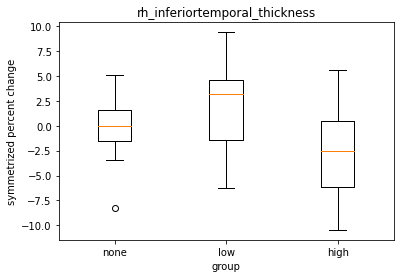

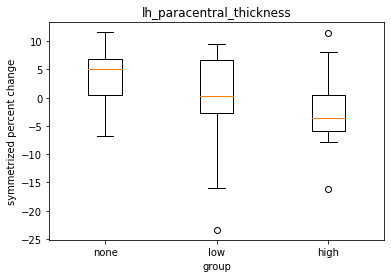

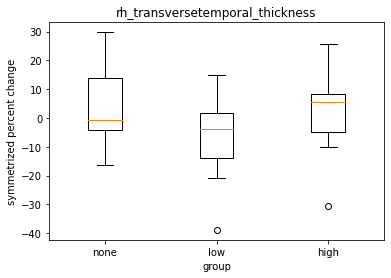

In [12]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

ftest_result_df = pd.DataFrame(index=[], columns=['spc', 'pval'])
tktest_result_df = pd.DataFrame(index=[], columns=['spc', 'group', 'pval'])
for ii in range(df_result.columns.get_loc('lh_bankssts_thickness'),df_result.columns.get_loc('rh_MeanThickness_thickness')+1):
    ftest_A=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 0),df_result.columns[ii]]
    ftest_B=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 1),df_result.columns[ii]]
    ftest_C=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 2),df_result.columns[ii]]

    # f test
    ftest_result=stats.f_oneway(ftest_A,ftest_B,ftest_C)
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii],ftest_result.pvalue]], columns=ftest_result_df.columns),ignore_index=True)
    
    # tukey test
    ftest_ABC=pd.concat([ftest_A, ftest_B, ftest_C])
    ftest_I=['none' for _ in range(ftest_A.shape[0])]+['low' for _ in range(ftest_B.shape[0])]+['high' for _ in range(ftest_C.shape[0])]
    temptkresult=vars(pairwise_tukeyhsd(ftest_ABC, ftest_I))
    tktest_result_df=tktest_result_df.append(pd.DataFrame([[df_result.columns[ii], temptkresult['groupsunique'][0], temptkresult['pvalues'][0]]], columns=tktest_result_df.columns),ignore_index=True)
    tktest_result_df=tktest_result_df.append(pd.DataFrame([[df_result.columns[ii], temptkresult['groupsunique'][1], temptkresult['pvalues'][1]]], columns=tktest_result_df.columns),ignore_index=True)
    tktest_result_df=tktest_result_df.append(pd.DataFrame([[df_result.columns[ii], temptkresult['groupsunique'][2], temptkresult['pvalues'][2]]], columns=tktest_result_df.columns),ignore_index=True)

print(ftest_result_df.sort_values('pval'))
#
print(tktest_result_df.sort_values('pval'))
#
import numpy as np
# 2 group tukey test in SPC with min p-value
for jj in range(3):
    minspcname=ftest_result_df.sort_values('pval')['spc'].reset_index(drop=True)[jj]
    ii=df_result.columns.get_loc(minspcname)
    """ftest_A=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 0),df_result.columns[ii]]
    ftest_B=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 1),df_result.columns[ii]]
    ftest_C=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 2),df_result.columns[ii]]"""
    ftest_A=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 0),minspcname]
    ftest_B=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 1),minspcname]
    ftest_C=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 2),minspcname]
    ftest_ABC=pd.concat([ftest_A, ftest_B, ftest_C])
    ftest_I=['none' for _ in range(ftest_A.shape[0])]+['low' for _ in range(ftest_B.shape[0])]+['high' for _ in range(ftest_C.shape[0])]
    print("")
    print(minspcname)
    print(pairwise_tukeyhsd(ftest_ABC, ftest_I))
    #plot
    fig,ax=plt.subplots()
    ax.boxplot([ftest_A,ftest_B,ftest_C],labels=["none","low","high"])
    plt.title(minspcname)
    plt.ylabel("symmetrized percent change")
    plt.xlabel("group")
    plt.savefig(IMPACT_CWD+"g2_figure_"+str(jj+1)+".png")

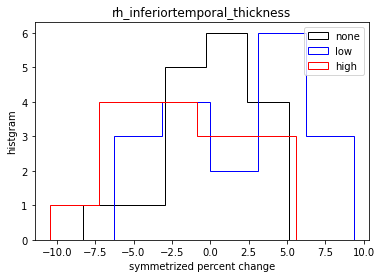

In [13]:
"""
#plot
minspcname=ftest_result_df.sort_values('pval')['spc'].reset_index(drop=True)[0]
ftest_A=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 0),['年齢_bl',minspcname]]
ftest_B=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 1),['年齢_bl',minspcname]]
ftest_C=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 2),['年齢_bl',minspcname]]
plt.plot(ftest_A['年齢_bl'],ftest_A[minspcname], color="k", label="none",marker="x", linestyle='None')
plt.plot(ftest_B['年齢_bl'],ftest_B[minspcname], color="b", label="low",marker="^", linestyle='None')
plt.plot(ftest_C['年齢_bl'],ftest_C[minspcname], color="r", label="high",marker="o", linestyle='None')
plt.title(minspcname)
plt.ylabel("symmetrized percent change")
plt.xlabel("age")
plt.legend()
plt.savefig('ageplot_figure.png')

#rh_cuneus_thickness
plt.figure()
minspcname="rh_cuneus_thickness"
ftest_A=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 0),['年齢_bl',minspcname]]
ftest_B=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 1),['年齢_bl',minspcname]]
ftest_C=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 2),['年齢_bl',minspcname]]
plt.plot(ftest_A['年齢_bl'],ftest_A[minspcname], color="k", label="none",marker="x", linestyle='None')
plt.plot(ftest_B['年齢_bl'],ftest_B[minspcname], color="b", label="low",marker="^", linestyle='None')
plt.plot(ftest_C['年齢_bl'],ftest_C[minspcname], color="r", label="high",marker="o", linestyle='None')
plt.title(minspcname)
plt.ylabel("symmetrized percent change")
plt.xlabel("age")
plt.legend()
plt.savefig('ageplot2_figure.png')
"""

plt.figure()
minspcname=ftest_result_df.sort_values('pval')['spc'].reset_index(drop=True)[0]
ftest_A=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 0),minspcname]
ftest_B=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 1),minspcname]
ftest_C=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 2),minspcname]
plt.hist(ftest_A, bins=5, histtype="step", color="k", label="none")
plt.hist(ftest_B, bins=5, histtype="step", color="b", label="low")
plt.hist(ftest_C, bins=5, histtype="step", color="r", label="high")
plt.title(minspcname)
plt.xlabel("symmetrized percent change")
plt.ylabel("histgram")
plt.legend()
plt.savefig(IMPACT_CWD+'f_figure.png')

In [14]:
from statsmodels.formula.api import ols

df_result['n運動習慣'] = 0
df_result['l運動習慣'] = 0
df_result['h運動習慣'] = 0
df_result.loc[(df_result['運動習慣_あり_運動時間'] == 0),'n運動習慣'] = 1
df_result.loc[(df_result['運動習慣_あり_運動時間'] == 1),'l運動習慣'] = 1
df_result.loc[(df_result['運動習慣_あり_運動時間'] == 2),'h運動習慣'] = 1
#print(df_result.head())
ftest_result_df = pd.DataFrame(index=[], columns=['spc', 'pval'])
for ii in range(df_result.columns.get_loc('lh_bankssts_thickness'),df_result.columns.get_loc('rh_MeanThickness_thickness')+1):
    ftest_A=df_result.loc[:,['年齢_bl','n運動習慣','l運動習慣','h運動習慣',df_result.columns[ii]]]
    #print(ftest_A.head())
    model=ols(df_result.columns[ii]+' ~ n運動習慣 + l運動習慣 + h運動習慣 + 年齢_bl', ftest_A).fit()
    #print(model.summary())
    ftest_result=model.f_test([0, 1, -0.5, -0.5, 0])
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii]+"_n",ftest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
    ftest_result=model.f_test([0, -0.5, 1, -0.5, 0])
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii]+"_l",ftest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
    ftest_result=model.f_test([0, -0.5, -0.5, 1, 0])
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii]+"_h",ftest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
print(ftest_result_df.sort_values('pval'))

                                    spc                  pval
131     rh_inferiortemporal_thickness_h  0.015599115181670826
205   rh_transversetemporal_thickness_l  0.021988665471894278
130     rh_inferiortemporal_thickness_l   0.02549733336815744
169          rh_postcentral_thickness_l   0.04678270347094067
115  rh_caudalmiddlefrontal_thickness_l   0.06087511445106366
..                                  ...                   ...
123             rh_fusiform_thickness_n    0.9816348233011339
145  rh_medialorbitofrontal_thickness_l    0.9863088650911775
55      lh_parstriangularis_thickness_l    0.9902386417230964
27      lh_lateraloccipital_thickness_n    0.9962731583390426
210        rh_MeanThickness_thickness_n    0.9987226288433456

[213 rows x 2 columns]



rh_cuneus_thickness
                             OLS Regression Results                            
Dep. Variable:     rh_cuneus_thickness   R-squared:                       0.239
Model:                             OLS   Adj. R-squared:                  0.152
Method:                  Least Squares   F-statistic:                     2.761
Date:                 Thu, 07 May 2020   Prob (F-statistic):             0.0297
Time:                         12:08:52   Log-Likelihood:                -176.11
No. Observations:                   50   AIC:                             364.2
Df Residuals:                       44   BIC:                             375.7
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.3506

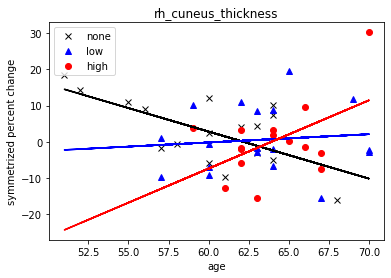

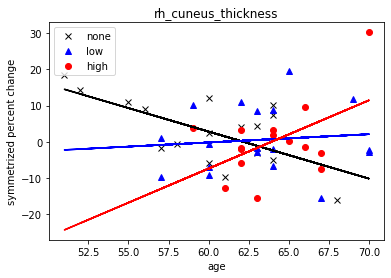

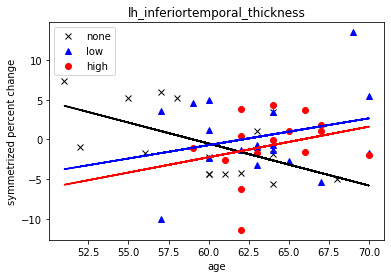

In [15]:
# different slope
df_result['n年齢_bl'] = 0
df_result['l年齢_bl'] = 0
df_result['h年齢_bl'] = 0
df_result.loc[(df_result['運動習慣_あり_運動時間'] == 0),'n年齢_bl'] = df_result['年齢_bl']
df_result.loc[(df_result['運動習慣_あり_運動時間'] == 1),'l年齢_bl'] = df_result['年齢_bl']
df_result.loc[(df_result['運動習慣_あり_運動時間'] == 2),'h年齢_bl'] = df_result['年齢_bl']
#print(df_result.head())
ftest_result_df = pd.DataFrame(index=[], columns=['spc', 'pval'])
for ii in range(df_result.columns.get_loc('lh_bankssts_thickness'),df_result.columns.get_loc('rh_MeanThickness_thickness')+1):
    ftest_A=df_result.loc[:,['n運動習慣','l運動習慣','h運動習慣','n年齢_bl','l年齢_bl','h年齢_bl',df_result.columns[ii]]]
    model=ols(df_result.columns[ii]+' ~ n運動習慣 + l運動習慣 + h運動習慣 + n年齢_bl + l年齢_bl + h年齢_bl', ftest_A).fit()
    ftest_result=model.f_test([0, 0, 0, 0, 1, -0.5, -0.5])
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii]+"_n",ftest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
    ftest_result=model.f_test([0, 0, 0, 0, -0.5, 1, -0.5])
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii]+"_l",ftest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
    ftest_result=model.f_test([0, 0, 0, 0, -0.5, -0.5, 1])
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii]+"_h",ftest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
#print(ftest_result_df.sort_values('pval'))

# correlation
for jj in range(3):
    minspcname=ftest_result_df.sort_values('pval')['spc'].reset_index(drop=True)[jj]
    """ftest_A=df_result.loc[:,['n運動習慣','l運動習慣','h運動習慣','n年齢_bl','l年齢_bl','h年齢_bl',df_result.columns[ii]]]
    model=ols(df_result.columns[ii]+' ~ n運動習慣 + l運動習慣 + h運動習慣 + n年齢_bl + l年齢_bl + h年齢_bl', ftest_A).fit()"""
    minspcname=minspcname[:-2]
    ftest_A=df_result.loc[:,['n運動習慣','l運動習慣','h運動習慣','n年齢_bl','l年齢_bl','h年齢_bl',minspcname]]
    model=ols(minspcname+' ~ n運動習慣 + l運動習慣 + h運動習慣 + n年齢_bl + l年齢_bl + h年齢_bl', ftest_A).fit()
    
    print("")
    print(minspcname)
    print(model.summary())
    #plot
    ftest_A=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 0),['年齢_bl',minspcname]]
    ftest_B=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 1),['年齢_bl',minspcname]]
    ftest_C=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 2),['年齢_bl',minspcname]]
    plt.figure()
    plt.plot(ftest_A['年齢_bl'],ftest_A[minspcname], color="k", label="none",marker="x", linestyle='None')
    plt.plot(ftest_B['年齢_bl'],ftest_B[minspcname], color="b", label="low",marker="^", linestyle='None')
    plt.plot(ftest_C['年齢_bl'],ftest_C[minspcname], color="r", label="high",marker="o", linestyle='None')
    #print(model.params["Intercept"])
    plt.plot(df_result['年齢_bl'],model.params["Intercept"]+model.params["n運動習慣"]+df_result['年齢_bl']*model.params["n年齢_bl"], color="k")
    plt.plot(df_result['年齢_bl'],model.params["Intercept"]+model.params["l運動習慣"]+df_result['年齢_bl']*model.params["l年齢_bl"], color="b")
    plt.plot(df_result['年齢_bl'],model.params["Intercept"]+model.params["h運動習慣"]+df_result['年齢_bl']*model.params["h年齢_bl"], color="r")
    plt.title(minspcname)
    plt.ylabel("symmetrized percent change")
    plt.xlabel("age")
    plt.legend()
    plt.savefig(IMPACT_CWD+"dods_corr_figure_"+str(jj+1)+".png")

In [16]:
#print(df_result)
corr_matp = df_result.corr(method='pearson')
#print(corr_matp)
corr_matp=corr_matp.dropna(how = 'all')
corr_matp=corr_matp.dropna(axis = 'columns')
corr_matp.to_csv(IMPACT_CWD+'spc_corr_matp.csv')

/home/s1613134/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36939 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/s1613134/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21205 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/s1613134/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/s1613134/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24931 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/s1613134/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/s1613134/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: 

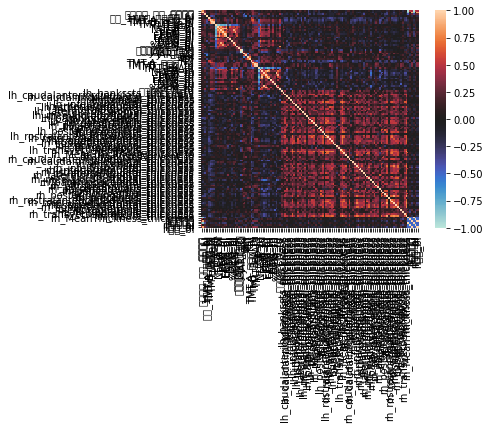

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(corr_matp,square=True,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=False, # True:格子の中に値を表示
#            fmt='.1f',
            xticklabels=corr_matp.columns.values,
            yticklabels=corr_matp.columns.values
           )
plt.show()
#fig = plt.figure(figsize=(10,10),dpi=200)
#fig.show()

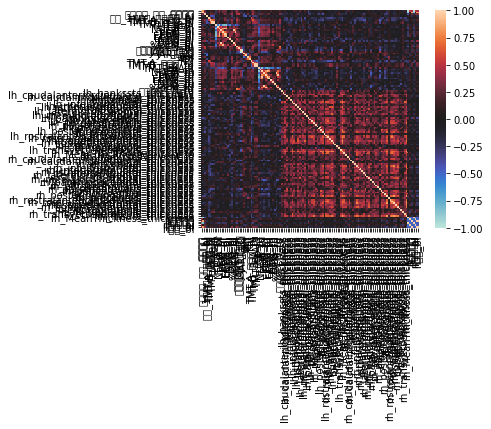

In [18]:
corr_mats = df_result.corr(method='spearman')
corr_mats=corr_mats.dropna(how = 'all')
corr_mats=corr_mats.dropna(axis = 'columns')
corr_mats.to_csv(IMPACT_CWD+'spc_corr_mats.csv')
sns.heatmap(corr_mats,square=True,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=False, # True:格子の中に値を表示
#            fmt='.1f',
            xticklabels=corr_mats.columns.values,
            yticklabels=corr_mats.columns.values
           )
plt.show()

In [19]:
#print(corr_matp)

In [20]:
#print(corr_mats)